In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson
import numpy as np
import torch
import torch.nn as nn
from time import time

In [2]:
print(torch.cuda.is_available())

True


In [3]:
class Utils:
    # Convert string parameter into torch activation function
    @staticmethod
    def get_activation_function(activation_function_str, negative_slope):
        if activation_function_str == "Lrelu":
            activation = torch.nn.LeakyReLU(negative_slope=negative_slope)
        elif activation_function_str == "relu":
            activation = torch.nn.ReLU()
        elif activation_function_str == "sigmoid":
            activation = torch.nn.Sigmoid()
        else:
            raise ValueError("Activation function not recognized : {}".format(activation_function_str))
        return activation
    
    # Convert string parameter into torch final activation function
    @staticmethod
    def get_final_activation_function(final_activation):
        if final_activation == "Sigmoid":
            final_activation = lambda x: torch.sigmoid(x)
        elif final_activation == "Clamping":
            final_activation = lambda x: torch.clamp(x, min=0., max=1.)
        elif final_activation == "Linear":
            final_activation = lambda x: x
        else:
            raise ValueError("final_activation must be Sigmoid, Clamping or Linear")
        return final_activation
    

In [4]:
class Conditional_Poisson_Generator(nn.Module):
    def __init__(self,
                 noise_size: int=1,
                 min_mu: int=1,
                 max_mu: int=1,



                 
                 hidden_dim: int=100,
                 activation_function: str="Lrelu",
                 final_activation: str="Sigmoid",
                 label_size: int=10,
                 negative_slope: float=0.1,
                 nb_hidden_layers_G: int=1,
                 eps: float=0.,
                 **kwargs):
        super(Conditional_Poisson_Generator, self).__init__()
        self.min_mu = min_mu
        self.max_mu = max_mu
        self.input_dim = noise_size
        self.nb_hidden_layers = nb_hidden_layers_G
        self.hidden_dim = hidden_dim
        self.activation = Utils.get_activation_function(activation_function, negative_slope)
        self.input_noise = nn.Linear(self.input_dim, self.hidden_dim)
        self.label_size = label_size
        self.input_label = nn.Linear(1, self.label_size)
        self.fcs = nn.ModuleList()
        self.eps = eps
        for i in range(self.nb_hidden_layers):
            if i == 0:
                self.fcs.append(nn.Linear(self.hidden_dim + self.label_size, self.hidden_dim))
            else:
                self.fcs.append(nn.Linear(self.hidden_dim, self.hidden_dim))
        self.output = nn.Linear(self.hidden_dim, 1)
        self.final_activation = Utils.get_final_activation_function(final_activation)
         
    def forward(self, x, mu):
        # Normalize mu with min_mu and max_mu into [0, 1]
        if self.max_mu == self.min_mu:
            mu = 1
        else:
            mu = (mu - self.min_mu) / (self.max_mu - self.min_mu)       
        return self.feed_forward(x, mu)
    
    def feed_forward(self, x, mu):
        x = self.activation(self.input_noise(x))
        mu = self.activation(self.input_label(mu))
        x = torch.cat((x, mu), 1)
        for i in range(self.nb_hidden_layers):
            x = self.activation(self.fcs[i](x))
        x = self.final_activation(self.output(x))
        return x + self.eps

In [6]:
params = {}

# tested_mus are mu values on which we will perform tests (KS divergence)
params["tested_mus"] = [0.8, 0.8, 1.5, 3, 6, 12, 20, 40, 500]
# Set min_mu == max_mu to train on one value for mu; otherwise, it will train on the interval and parametrize G and D 
params["min_mu"] = 0.8
params["max_mu"] = 30
# alpha: poisson.ppf(alpha) is network's max return value.
# Because network return values are bounded in [0,1], 1 has to have a draw equivalent which is poisson.ppf(alpha)
params["alpha"] = 0.999

# Networks parameters
# Number of uniform draws for G
params["noise_size"] = 4
# Hidden layer size for mu inputs when parametrized (leaving it at 10 is satisfactory)
params["label_size"] = 10
# "Lrelu", "relu" or "sigmoid" (default Lrelu with negative slope 0.1)
params["activation_function"] = "Lrelu"
params["negative_slope"] = 0.1
# Final activation for Generator: Sigmoid, Linear or Clamping
params["final_activation"] = "Linear"
# hidden layer size
params["hidden_dim"] = 100
# number of hidden layers for both D and G after input layer (default 1) : total number of hidden layers is nb_hidden_layers + 1
params["nb_hidden_layers_G"] = 1
params["nb_hidden_layers_D"] = 1

params["device"] = torch.device('cuda:0')

# Path parameters
# Load_dir_model is the folder containing the model to load
params["load_dir_model"] = "checkpoints_Poisson"
# CUDA (might not work, to be tested)
params["cuda"] = True
# In case cuda = True, pick GPU number :
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [7]:
poisson_checkpoint = torch.load(params["load_dir_model"], map_location='cpu')
poisson_generator = Conditional_Poisson_Generator(**params).to('cpu')
poisson_generator.load_state_dict(poisson_checkpoint['generator_state_dict'])

print(poisson_checkpoint['epoch'])


56


In [10]:
def Poisson_generator(G, mu, size, noise_size,  max_mu, device, **kwargs) :
    G = G.to(device)
    M = poisson.ppf(0.999, max_mu)
    if mu > max_mu:
        _mu = max_mu
    else:
        _mu = mu
    uniform = torch.rand(size, noise_size, device = device)
    mus = torch.ones(size, 1, device = device)*_mu
    simulated_poisson_draws = G(uniform, mus) * M
    if mu > _mu :
        simulated_poisson_draws = (simulated_poisson_draws - _mu) / np.sqrt(_mu) * np.sqrt(mu) + mu 
    simulated_poisson_draws = torch.round(simulated_poisson_draws)
    return simulated_poisson_draws

In [11]:
def Poisson_generator2(uniform, G, mu, size, noise_size,  max_mu, device, **kwargs) :
    G = G.to(device)
    M = poisson.ppf(0.999, max_mu)
    if mu > max_mu:
        _mu = max_mu
    else:
        _mu = mu
    mus = torch.ones(size, 1, device = device)*_mu
    simulated_poisson_draws = G(uniform, mus) * M
    if mu > _mu :
        simulated_poisson_draws = (simulated_poisson_draws - _mu) / np.sqrt(_mu) * np.sqrt(mu) + mu 
    simulated_poisson_draws = torch.round(simulated_poisson_draws)
    return simulated_poisson_draws

Plot histograms on tested_mus.

0.8
stats time = 0.037897586822509766
uniform  time= 0.09474635124206543
poisson with torch time = 0.07606196403503418
GAN (with uniform generation) time = 1.1599006652832031
GAN (without uniform generation) time = 2.09739089012146 



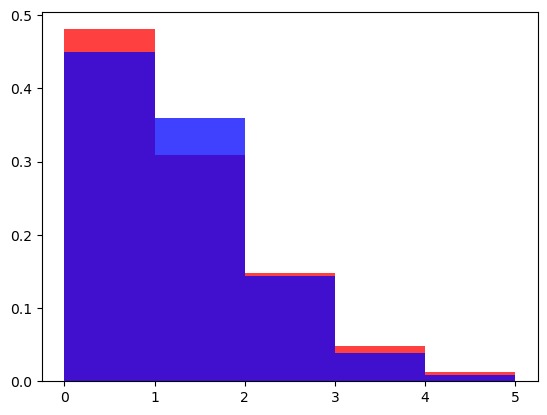

0.8
stats time = 0.05086350440979004
uniform  time= 0.000997304916381836
poisson with torch time = 0.0009970664978027344
GAN (with uniform generation) time = 0.13862848281860352
GAN (without uniform generation) time = 0.5993969440460205 



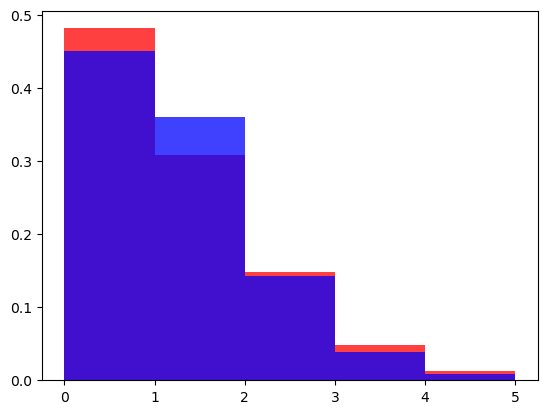

1.5
stats time = 0.04786992073059082
uniform  time= 0.000997781753540039
poisson with torch time = 0.0009970664978027344
GAN (with uniform generation) time = 0.13862872123718262
GAN (without uniform generation) time = 0.5575089454650879 



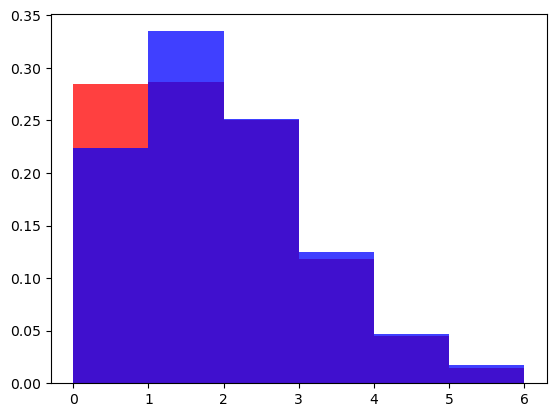

3
stats time = 0.05684781074523926
uniform  time= 0.000997781753540039
poisson with torch time = 0.0009975433349609375
GAN (with uniform generation) time = 0.1386575698852539
GAN (without uniform generation) time = 0.5744354724884033 



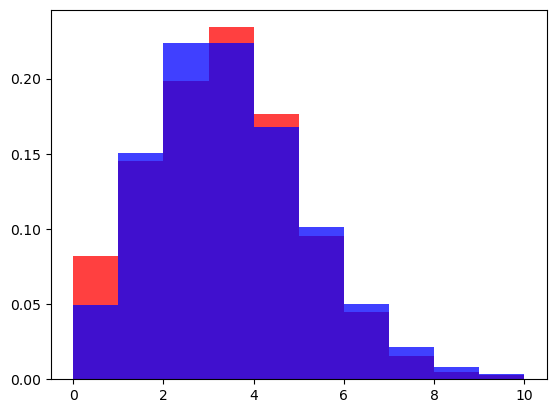

6
stats time = 0.07679629325866699
uniform  time= 0.0009975433349609375
poisson with torch time = 0.0009963512420654297
GAN (with uniform generation) time = 0.13962769508361816
GAN (without uniform generation) time = 0.5305795669555664 



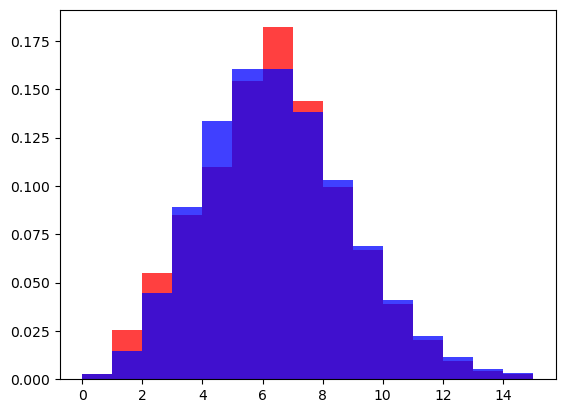

12
stats time = 0.08177876472473145
uniform  time= 0.0009980201721191406
poisson with torch time = 0.0019936561584472656
GAN (with uniform generation) time = 0.13862943649291992
GAN (without uniform generation) time = 0.5555143356323242 



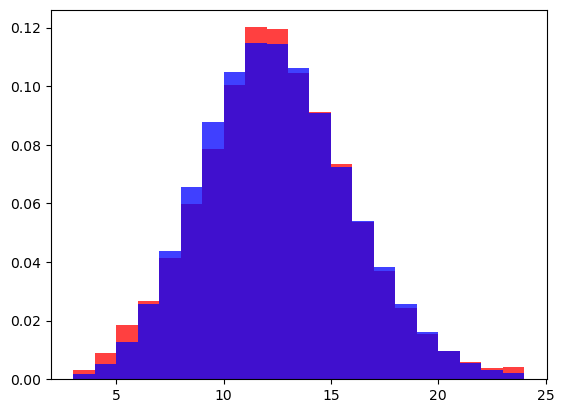

20
stats time = 0.0718073844909668
uniform  time= 0.0009980201721191406
poisson with torch time = 0.0019936561584472656
GAN (with uniform generation) time = 0.13962650299072266
GAN (without uniform generation) time = 0.531578540802002 



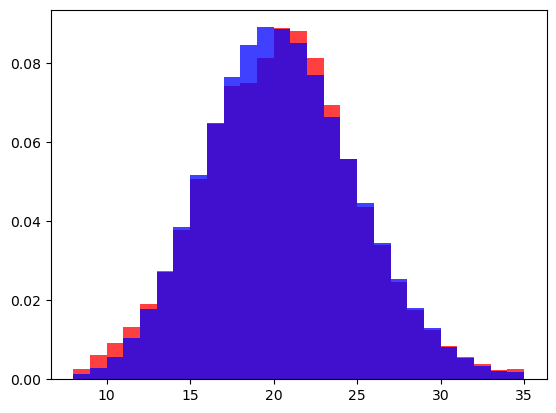

40
stats time = 0.06482696533203125
uniform  time= 0.0
poisson with torch time = 0.00501561164855957
GAN (with uniform generation) time = 0.13959813117980957
GAN (without uniform generation) time = 0.5166177749633789 



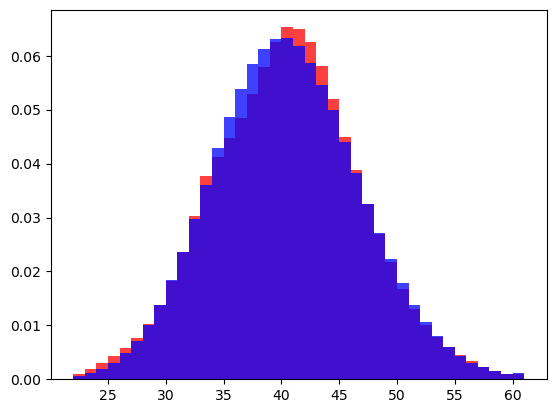

500
stats time = 0.05485177040100098
uniform  time= 0.0
poisson with torch time = 0.007978439331054688
GAN (with uniform generation) time = 0.13962650299072266
GAN (without uniform generation) time = 0.5076436996459961 



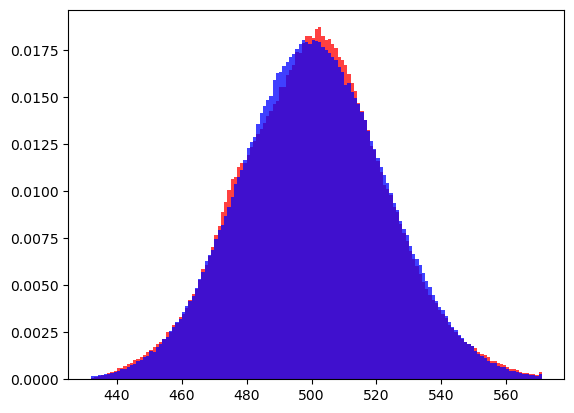

In [12]:
size = int(1e6)
for MU in params["tested_mus"] :
    print(MU)

    _min = math.floor(poisson.ppf(1 - params['alpha'], MU))
    _max = math.ceil(poisson.ppf(params['alpha'], MU))
    bins = np.linspace(_min, _max, _max - _min + 1)
    t_ = time()
    true_poisson_np = poisson.rvs(MU, size = size)
    print("stats time =", time()-t_)
    t_ = time()
    uniform = torch.rand(size, 4, device = torch.device('cuda:0'))
    torch.cuda.synchronize(device = torch.device('cuda:0'))
    print("uniform  time=", time()-t_)

    t_ = time()
    true_poisson_torch = torch.poisson(torch.ones(size, device = torch.device('cuda:0'))*MU)
    torch.cuda.synchronize(device = torch.device('cuda:0'))
    print("poisson with torch time =", time()-t_)
    
    t_ = time()
    GAN_poisson = Poisson_generator(poisson_generator, mu = MU, size = size, **params)
    torch.cuda.synchronize(device = torch.device('cuda:0'))
    print("GAN (with uniform generation) time =", time()-t_)
    
    t_ = time()
    GAN_poisson = Poisson_generator2(uniform, poisson_generator, mu = MU, size = size, **params)
    torch.cuda.synchronize(device = torch.device('cuda:0'))
    print("GAN (without uniform generation) time =", time()-t_, "\n")
    
    GAN_poisson = np.array(GAN_poisson.detach().cpu().numpy())    
    plt.hist(GAN_poisson, bins=bins, alpha=0.75, color = 'red', density=True, label="32 bit distribution")
    plt.hist(true_poisson_np, bins=bins, alpha=0.75,  color = 'blue', density=True, label="Simulated distribution")
    plt.show()
